# Principal Component Analysis (PCA)

Sources: Some part of the PCA implementation comes from the tutorials section of the MML book. 

Link:  https://mml-book.github.io/ (by Marc Deisenroth and Yicheng Luo)

Additional Content: Rahul Narkhede, Prof. Bernhard Eidel

### TASKS 
- We will implement PCA using the projection perspective. The MNIST (hand-written digits) dataset is used to illustrate application of PCA. 
- We will implement Logistic Regression and use PCA along with it to conduct binary classification of two digits from the MNIST dataset. 

In [77]:
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
import seaborn as sns
import random
from scipy import stats as st
from scipy.spatial.distance import cdist
import statistics as st

%matplotlib inline

## An illustration

Let us generate a random cluster of points sampled from the Gaussian distribution and try to find the best fit line for projection. Recall, we want to preserve the variance, as much as we can.

Total variance of the original data: 8.7576
Variance preserved by the principal component: 8.3679 (Ratio: 0.9555)
Variance preserved by arbitrary line 1: 6.3610 (Ratio: 0.7263)
Variance preserved by arbitrary line 2: 0.6690 (Ratio: 0.0764)


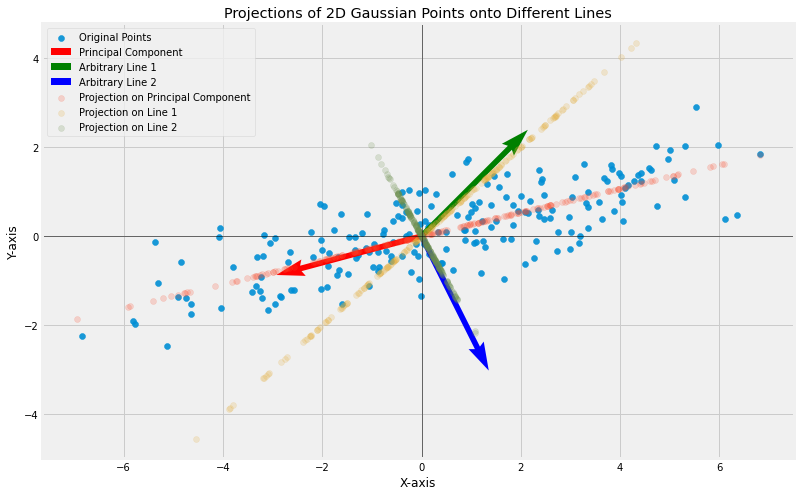

In [107]:
# Generate 2D Gaussian points
mean = np.array([0, 0])
cov = np.array([[8, 2], [2, 1]])
points = np.random.multivariate_normal(mean, cov, 200)

#Perform PCA to find the direction that maximizes variance
cov_matrix = np.cov(points, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
principal_component = eigenvectors[:, -1]  # The eigenvector with the largest eigenvalue

# Define two other arbitrary lines
line1 = np.array([1.0, 1.0])  # An arbitrary line direction
line2 = np.array([1.0, -2.0])  # Another arbitrary line direction

# Normalize the line directions
line1 /= np.linalg.norm(line1)
line2 /= np.linalg.norm(line2)

# Project points onto the lines
proj_pca = points @ principal_component
proj_line1 = points @ line1
proj_line2 = points @ line2

# Calculate the variances of the projections
variance_pca = np.var(proj_pca)
variance_line1 = np.var(proj_line1)
variance_line2 = np.var(proj_line2)

# Calculate the total variance of the original data
total_variance = np.sum(eigenvalues)

# Calculate variance ratios
variance_ratio_pca = variance_pca / total_variance
variance_ratio_line1 = variance_line1 / total_variance
variance_ratio_line2 = variance_line2 / total_variance

# Print the variances and variance ratios
print(f"Total variance of the original data: {total_variance:.4f}")
print(f"Variance preserved by the principal component: {variance_pca:.4f} (Ratio: {variance_ratio_pca:.4f})")
print(f"Variance preserved by arbitrary line 1: {variance_line1:.4f} (Ratio: {variance_ratio_line1:.4f})")
print(f"Variance preserved by arbitrary line 2: {variance_line2:.4f} (Ratio: {variance_ratio_line2:.4f})")

# Visualization
plt.figure(figsize=(12, 8))

# Plot original points
plt.scatter(points[:, 0], points[:, 1], alpha=0.9, label='Original Points')

# Plot the principal component line
plt.quiver(0, 0, principal_component[0], principal_component[1], 
           color='r', scale=5, label='Principal Component')

# Plot the other two lines
plt.quiver(0, 0, line1[0], line1[1], color='g', scale=5, label='Arbitrary Line 1')
plt.quiver(0, 0, line2[0], line2[1], color='b', scale=5, label='Arbitrary Line 2')

# Projected points
proj_points_pca = np.outer(proj_pca, principal_component)
proj_points_line1 = np.outer(proj_line1, line1)
proj_points_line2 = np.outer(proj_line2, line2)

# Plot projected points
plt.scatter(proj_points_pca[:, 0], proj_points_pca[:, 1], alpha=0.2, label='Projection on Principal Component')
plt.scatter(proj_points_line1[:, 0], proj_points_line1[:, 1], alpha=0.2, label='Projection on Line 1')
plt.scatter(proj_points_line2[:, 0], proj_points_line2[:, 1], alpha=0.2, label='Projection on Line 2')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Projections of 2D Gaussian Points onto Different Lines')
plt.grid(True)
plt.show()


## PCA with MNIST dataset

We will load the MNIST dataset, which is readily available in `sklearn.datasets` and is a good dataset to learn classification methods in machine learning.

In [79]:
# import MNIST dataset (might take a few seconds)

from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, parser = 'auto')

In [80]:
# check the datatype and shape of the data

print(type(images), images.shape)
print(type(labels), labels.shape)


<class 'pandas.core.frame.DataFrame'> (70000, 784)
<class 'pandas.core.series.Series'> (70000,)


In [81]:
labels.unique()

['5', '0', '4', '1', '9', '2', '3', '6', '7', '8']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [82]:
# if not in NumPy, convert the data to NumPy array

images = np.array(images)
labels = np.array(labels)

# check the shape of an individual image sample
print(type(images[0]), images[0].shape)
print(type(labels[0]), labels[0])

<class 'numpy.ndarray'> (784,)
<class 'str'> 5


In [83]:
# select 1000 samples from the whole MNIST dataset
num_datapoints = 1000
# some preprocessing
X = (images.reshape(-1, 28*28)[:num_datapoints])/ 255 
# dividing by 255 will scale pixel values between [0, 1]
y = labels.astype(float) #convert string labels to float
y = y[:num_datapoints]

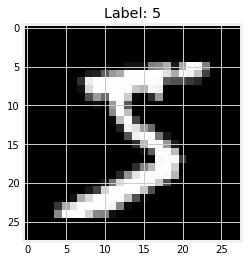

In [84]:
# plot an image
def image_plotter(X, ix):
    plt.figure(figsize = (4, 4))
    plt.imshow(X[ix].reshape(28, 28), cmap = 'gray')
    plt.title('Label: '+ labels[ix])
    
image_plotter(X, 0)

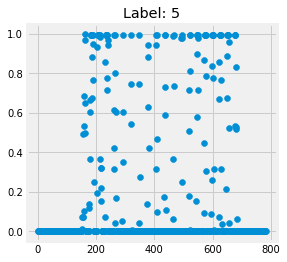

In [85]:
# how computers might be interpreting images

def plot_pixel_values(X, ix):
    plt.figure(figsize = (4, 4))
    plt.scatter(np.arange(784), X[ix])
    plt.title('Label: ' + labels[ix])
    
plot_pixel_values(X, 0)

## Setting up PCA (theory)

![PCA_Process.png](PCA_Process.png)

Explanation in exercise session.

## Setting up PCA (code)

**Steps:**

- 1) Normalize the data.
- 2) Create a covariance matrix.
- 3) Compute eigenvectors and eigenvalues of covariance matrix, and sort them in a descending order. 
- 4) Create matrix **B** and reduce the dimension of data (encode).
- 5) Create projection matrix to reconstruct the compressed data (decode).
- 6) De-normalize the reconstructions to plot images again.

**Python functions that can be of use:**
- `np.mean()` and `np.std()` for mean and standard deviation of numpy matrices.

- `np.linalg.eig()` for Eigendecomposition of a matrix.

- `np.argsort()` for sorting an array and returning the sorted indices. 

- `np.real()` to return the real component of complex arguments. 


Use `help()` to read the documentation of these functions in the Jupyter Notebook and try to implement PCA using the template below. 

In [123]:
# WILL NOT RUN UNTIL CODE IS COMPLETED

def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    # Compute mean and standard deviation of X
    mu = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    
    # Replace components of standard deviation which are zero to one.
    # This avoids division by zero error in the normalizing step
    std_filled = std.copy()
    std_filled[std == 0] = 1
    
    # Normalize X
    Xbar = (X - mu) / std_filled
    
    
    return Xbar, mu, std

def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    
    # Eigendecompositon of covariance matrix S
    eigvals, eigvecs = np.linalg.eig(S)
    
    # sorting the indices of eigenvals in descending order
    k = np.argsort(eigvals)[::-1]
    
    return eigvals[k], eigvecs[:,k]

def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    return (B @ np.linalg.inv(B.T @ B) @ B.T)

def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """
    # X is the normalized data so with zero mean and unit variance
    
    # Then compute the data covariance matrix S
    S = 1/len(X)*(np.dot(X, X.T))

    # Next find eigenvalues and corresponding eigenvectors for S 
    # which are also sorted in descending order of eigenvalues
    eig_vals, eig_vecs = eig(S)

    # find indices for the largest eigenvalues, use them to sort the eigenvalues and corresponding eigenvectors. 
    eig_vals, eig_vecs = eig_vals[0:num_components], eig_vecs[0:num_components]

    # dimensionality reduction of the original data
    B = np.real(np.array(eig_vecs))
    
    Z = np.dot(B.T, X)
    # reconstruct the images from the lower dimensional representation
    
    reconst = np.dot(projection_matrix(B), Z) 
    
    return reconst.T


In [124]:
Xbar, mu, std = normalize(X)

In [122]:
S = np.random.rand(100).reshape(10, 10)
v, vec = eig(S)
print(v.shape, vec.shape)

(10,) (10, 10)


In [ ]:
# WILL NOT RUN UNTIL CODE ABOVE IS COMPLETED

# checking if our setup works

Xbar, mu, std = normalize(X)

for num_component in range(1, 20):
    from sklearn.decomposition import PCA as SKPCA
    
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    
    # Using our setup
    reconst = PCA(Xbar, num_component)
    
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(num_component, "|", np.square(reconst - sklearn_reconst).sum())

    
    

We can notice that the squared error between the image reconstructed using our `PCA` function and that from sklearn's `pca.inverse_transform` is close to zero. This means our setup is working. 

Ideally, the greater the number of principal components we use, the smaller will our reconstruction error be. Let us try to answer the following: 

> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $100$ for our dataset?

In [86]:
# create error metric

def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [ ]:
# WILL NOT RUN UNTIL CODE IN PREVIOUS BLOCKS IS COMPLETED

loss = []
reconstructions = []

# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)


In [ ]:
# WILL NOT RUN UNTIL CODE IS COMPLETED

reconstructions.shape #99 components, 1000 images, 28*28 flattenend to a vector

In [ ]:
# WILL NOT RUN UNTIL CODE IN PREVIOUS BLOCKS IS COMPLETED

# plot change in mse as we increase the number of principal components
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But _numbers dont't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease from around
$450.0$ to less than $100.0$?

Let's find out! In the next cell, we draw the the leftmost image is the original dight. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [ ]:
# WILL NOT RUN UNTIL CODE IN PREVIOUS BLOCKS IS COMPLETED

@interact(image_idx=(0, 999))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    xtick_labels = np.arange(0, 100, 10)
    xtick_pos = [(14 + 28*loc) for loc in range(0, 10)]
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.set_xticks(xtick_pos, xtick_labels)
    
    ax.axvline(28, color='orange', linewidth=2)

In [ ]:
# WILL NOT RUN UNTIL CODE IN PREVIOUS BLOCKS IS COMPLETED

@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

## PCA implementation using a Class

Using individual functions to implement PCA is fine, but lets create a class which does the same for us.

Looking at the implementation of PCA using individual functions, try to fill the code in the template of `MyPCA` class. 

Classes are an efficient way to implement transformations and models. 

In [ ]:
# WILL NOT RUN UNTIL CODE IS COMPLETED

class MyPCA:
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self, X, mu = None, std = None):
        # Make a copy of the data
        X = X.copy()
        #print("X shape:", X.shape)
        
        # Calculate mean and standard deviation
        # Make a provision that allows the user
        # to specify mu and std. 
        # The user input mu and std should then be used for normalizing the data 
        # if no user input for mu and std, then compute them from X
        
        
        
        
        
        # Normalize the data
        
        
        # Calculate covariance matrix
        
        
        # Eigendecomposition
        
        
        # Ensure eigenvalues and eigenvectors are real
        
        
        # Sort eigenvalues and eigenvectors
       
        
        # Select top n_components eigenvectors
        
        
        #print("B matrix shape:", self.B_matrix.shape)
        
        return self
    
    def transform(self, X):
        # Make a copy of the data
        X = X.copy()
        
        # Normalize the data
        
        #print("X std shape:", X_std.shape)
        
        # Project the data onto the new space
        
        
        return Z
    
    def inverse_transform(self, X):
        # Project back to original space
        
        
        # Reverse the normalization
        
        
        # Ensure the result is real
        reconst = np.real(reconst)
        
        return reconst
    
    def explained_variance(self):
        # Total variance is the sum of eigenvalues
        total_variance = np.sum(self.eig_vals)

        # Explained variance for each component
        explained_variance = self.eig_vals[:self.n_components] / total_variance
        
        return explained_variance


In [ ]:
# WILL NOT RUN UNTIL CODE IN PREVIOUS BLOCKS IS COMPLETED

#normalize data by an external function
Xbar, mu, std = normalize(X)

In [ ]:
# WILL NOT RUN UNTIL CODE IN PREVIOUS BLOCKS IS COMPLETED

mypca = MyPCA(10)
mypca.fit(X, mu, std) #we provide mu and std to enforce mypca to use the given statistics
z = mypca.transform(X)
#print(z.shape)

reconst = mypca.inverse_transform(z)
#print(reconst.shape)
total_expl_variance_ratio = np.sum(mypca.explained_variance())
print("total explained variance ratio: ", total_expl_variance_ratio.round(4))

In [ ]:
image_plotter(X, 25)

In [ ]:
# WILL NOT RUN UNTIL CODE IN PREVIOUS BLOCKS IS COMPLETED

image_plotter(reconst, 25)

### PCA with scikit learn

We will see how PCA can be implemented with sklearn. It functions similar to our class `MyPCA`. 

In [87]:
# Normalizing using sklearn (or you can also use our normalize function from above)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #create instance
Xbar = scaler.fit_transform(X) # fit and transform
#print(scaler.mean_, scaler.var_)

In [88]:
from sklearn.decomposition import PCA as SKPCA

# create an instance
skpca = SKPCA(n_components = 10)

# we use the normalized data, Xbar
skpca.fit(Xbar)

# transform data to reduced dimensionality
X_reduced = skpca.transform(Xbar)

# reconstruct data to original dimensions
X_reconst = skpca.inverse_transform(X_reduced)

# explained variance
explained_variance_ratio = skpca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

#print(f"Explained Variance:\n{explained_variance_ratio}")
print(f"Total Explained Variance: {total_explained_variance_ratio:.4f}")

Total Explained Variance: 0.3439


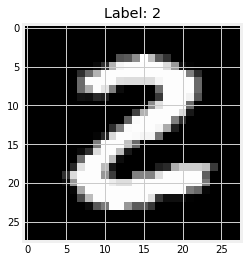

In [89]:
image_plotter(X, 25)

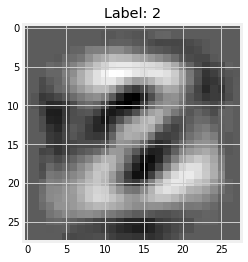

In [90]:
image_plotter(X_reconst, 25)

In [ ]:
# WILL NOT RUN UNTIL CODE IS COMPLETED

# we still use the same statistics: mu, std, and the normalized data Xbar for comparison

for num_component in range(1, 20):
    from sklearn.decomposition import PCA as SKPCA
    
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    
    
    # Using MyPCA
    # create instance
    pca_ = ...
    # fit 
    # transform
    z =   # Transform using standardized data Xbar
    # inverse transfrom 
    reconst = 
    
    # Compare reconstructions
    np.testing.assert_almost_equal(reconst, sklearn_reconst, decimal=2)
    print(num_component, "| Difference:", np.square(reconst - sklearn_reconst).sum())


## Visualizing MNIST dataset with PCA

Let's use PCA to reduce the dimensionality of the MNIST dataset to 2D and 3D. Then we plot the dataset with the reduced dimensionality. 

Use the MyPCA class to implement PCA in the plot function. 

In [91]:
def plot_mnist_pca(X, y, n_components=2):
    
    # sklearn implementation
    Xbar = scaler.fit_transform(X)
    pca = SKPCA(n_components=n_components)
    pca.fit(Xbar)
    X_pca = pca.transform(Xbar)
    
    # Apply MyPCA
    # create instance
    # fit
    # transform train and test dataset
    # X_pca = ...
    
    
    plt.figure(figsize=(8, 8))
    
    if n_components == 1:
        plt.scatter(X_pca, np.zeros_like(X_pca), c=y, cmap = 'tab10', alpha=0.7)
        plt.colorbar()
        plt.title('MNIST dataset visualized in 1D')
        plt.xlabel('Principal Component 1')
        plt.show()
    
    elif n_components == 2:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap = 'tab10', alpha=0.7)
        plt.colorbar()
        plt.title('MNIST dataset visualized in 2D')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()
    
    elif n_components == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap = 'tab10', alpha=0.7)
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)
        ax.set_title('MNIST dataset visualized in 3D')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        plt.subplots_adjust(left=0.1, right=1.2, top=0.9, bottom=0.1)  # Manually adjust the margins
        plt.show()
    else:
        raise ValueError("n_components must be 2 or 3")

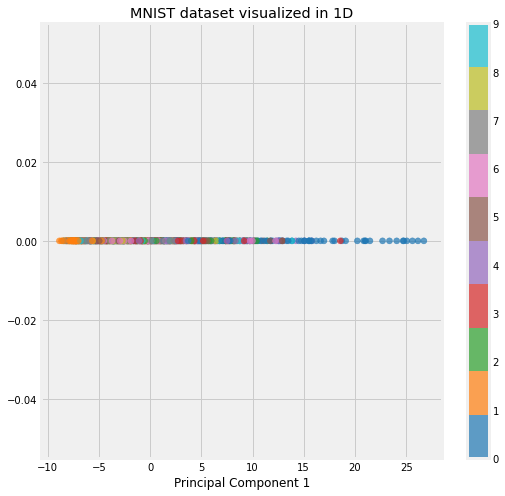

In [92]:
plot_mnist_pca(X, y, 1)

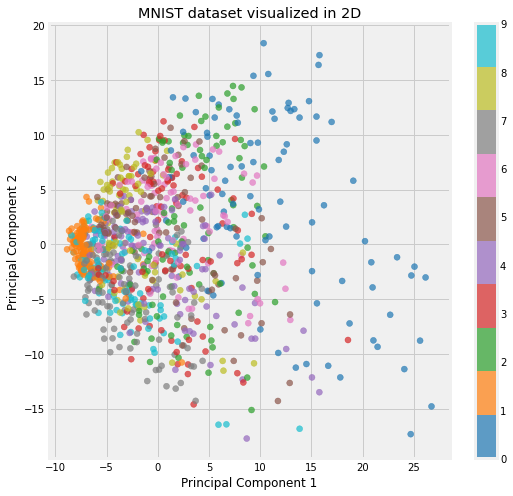

In [93]:
plot_mnist_pca(X, y, 2)

<Figure size 576x576 with 0 Axes>

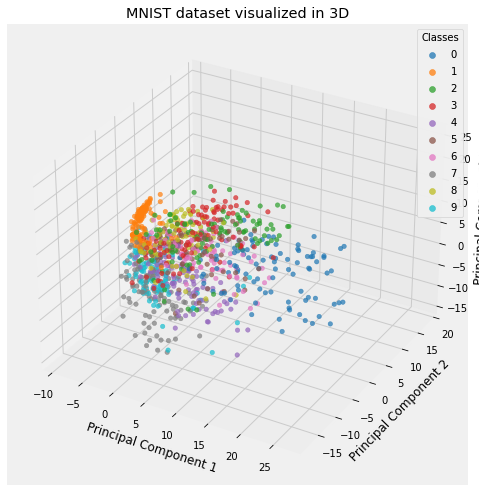

In [94]:
plot_mnist_pca(X, y, 3)

In [95]:
selections = [2, 9]

selected_ixs = np.isin(y[:1000], selections)
X_selected = X[selected_ixs]
y_selected = y[selected_ixs]

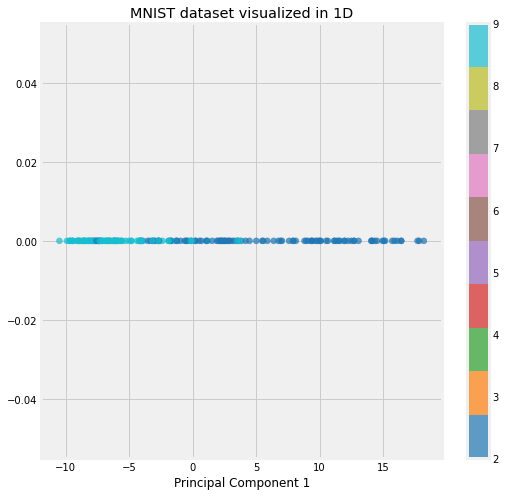

In [96]:
plot_mnist_pca(X_selected, y_selected, n_components = 1)

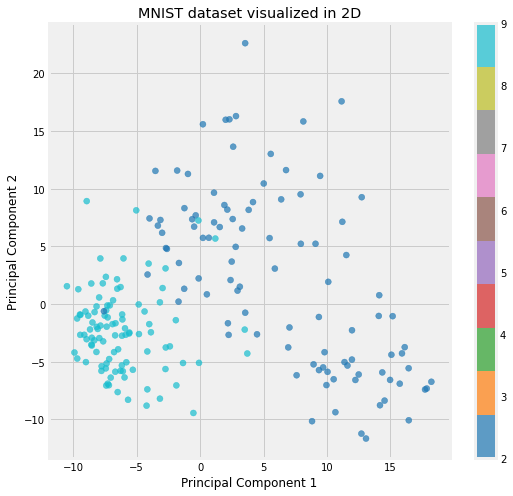

In [97]:
plot_mnist_pca(X_selected, y_selected, n_components = 2)

<Figure size 576x576 with 0 Axes>

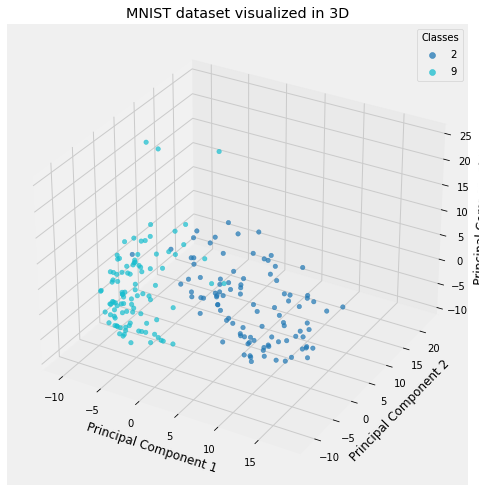

In [98]:
plot_mnist_pca(X_selected, y_selected, n_components = 3)

## Logistic Regression with PCA

### Understanding logistic regression (as an extension to linear regression)

Explanation in exercise session!

## Implementing logistic regression

We shall implement a very simplified version of logistic regression (without regularization) as a class.

Text(0.5, 1.0, 'Original values of x')

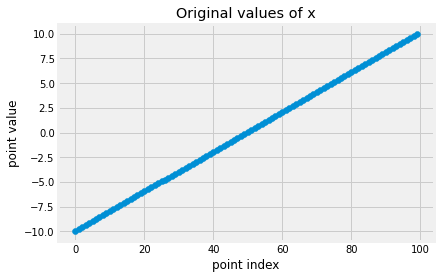

In [99]:
def logistic_function(z):
    return 1 / (1 + np.exp(-z))

# Define the range of x-values
x = np.linspace(-10, 10, 100)  # 1000 points between -10 and 10
# Calculate the sigmoid values
y = logistic_function(x)

plt.scatter(np.arange(0, len(x)), x)
plt.xlabel('point index')
plt.ylabel('point value')
plt.title('Original values of x')

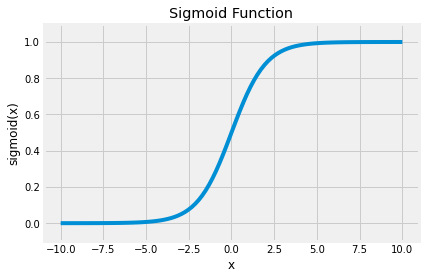

In [100]:
# Plot the graph
plt.plot(x, y)
# Add labels and title
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.title("Sigmoid Function")
# Set limits slightly bigger than range of function
plt.xlim([-11, 11])
plt.ylim([-0.1, 1.1])
# Grid
plt.grid(True)
# Show the plot
plt.show()

## Implementing logistic regression

We shall implement a very simplified version of logistic regression (without regularization) as a class. 

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

class LogisticRegression:
    def __init__(self, classes, learning_rate=0.00001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.classes = classes
        self.losses = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def initialize_params(self, num_features):
        # intialization of params for gradient descent
        self.weights = np.zeros((num_features, 1))
        self.bias = 0
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.initialize_params(num_features)
        #Ensure y is a column vector
        y = y.reshape(-1, 1)
        for _ in range(self.num_iterations):
            # implement linear model
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function
            y_predicted = self.sigmoid(linear_model)
            #print(X.shape, y_predicted.shape)
            
            # compute derivatives of cost function w.r.t params
            dw = (1/num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/num_samples) * np.sum(y_predicted - y)
            #print(dw.shape)
            
            # update weights and biases
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Compute loss and save it
            y_predicted_clipped = np.clip(y_predicted, 1e-15, 1 - 1e-15) # to avoid divide by zero error
            loss = -np.mean(y * np.log(y_predicted) + (1 - y) * np.log(1 - y_predicted))
            self.losses.append(loss)
            
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        # get probability of object being of class 1
        y_predicted = self.sigmoid(linear_model)
        
        # with a threshold of 0.5, assign class 1 or class 2
        y_predicted_cls = [self.classes[0] if i > 0.5 else self.classes[1] for i in y_predicted]
        return np.array(y_predicted_cls)

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [102]:
# select 60000 samples from the whole MNIST dataset
num_datapoints = 60000
# some preprocessing
X = (images.reshape(-1, 28*28)[:num_datapoints])/ 255 
# dividing by 255 will scale pixel values between [0, 1]
y = labels.astype(float) #convert string labels to float
y = y[:num_datapoints]

In [103]:
 #examples each of class '0' and class '1' are taken from dataset
classes = [7, 5]
y_binary = np.concatenate([y[y==classes[0]], y[y==classes[1]]])
X_binary = np.concatenate([X[y==classes[0]], X[y==classes[1]]])

Accuracy: 0.979


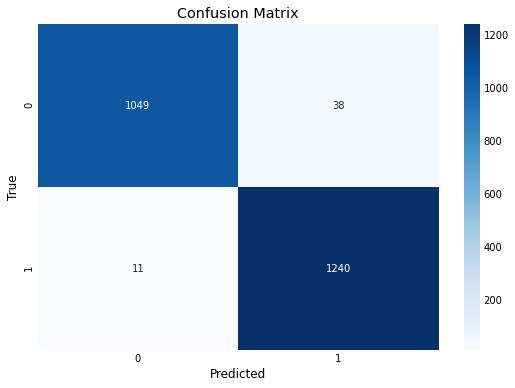

Text(0, 0.5, 'Loss')

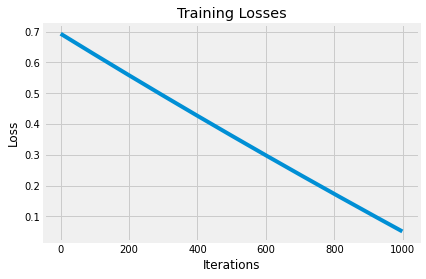

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply sklearn PCA
pca = SKPCA(n_components=100)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Apply MyPCA
# create instance
# fit
# transform train and test dataset
# X_train_reduced = ...
# X_test_reduced = ...

# Create and train the logistic regression model
model = LogisticRegression(classes)
model.fit(X_train_reduced, y_train)

# Make predictions on the testing set
predictions = model.predict(X_test_reduced)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print("Accuracy:", accuracy.round(3))
plot_confusion_matrix(y_test, predictions)

# Plot training losses
plt.plot(model.losses)
plt.title('Training Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss')
#plt.show()

In [105]:
# might take a minute or two to run...

accuracies = []

# try to see the effect of components ranging in [2, 100]

for n_component in range(1, 20): 
    # Apply sklearn PCA
    pca = SKPCA(n_components=n_component)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # Apply MyPCA
    # create instance
    # fit
    # transform train and test dataset
    # X_train_reduced = ...
    # X_test_reduced = ...

    # Create and train the logistic regression model
    model = LogisticRegression(classes)
    model.fit(X_train_reduced, y_train)

    # Make predictions on the testing set
    predictions = model.predict(X_test_reduced)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)

    #print("Accuracy:", accuracy.round(3))
    accuracies.append(accuracy)



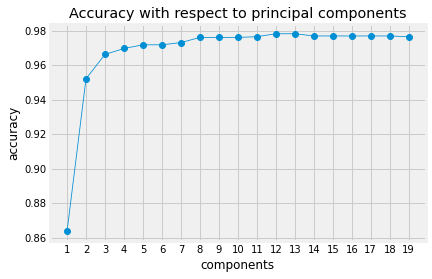

In [106]:
# plot change in accuracy as number of components increase
plt.plot(np.arange(1, 20, 1), accuracies, marker = 'o', linewidth = 0.8)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel('components')
plt.ylabel('accuracy')
plt.title('Accuracy with respect to principal components')
plt.show()

## Logistic Regression using sklearn

Implement logistic regression without regularization using the sklearn library. 

Use `MyPCA` for reducing dimensionaltiy and check the effect of number of components on the accuracy.

In [ ]:
# import functions